In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Objective:
## Train a 3D U-Net based model with Multi-Scale Attention to predict heatmaps indicating potential lung nodule location on the LUNA16 Dataset. Map predictions back to real-world coordinates.

In [2]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 45.8 MB/s eta 0:00:00


In [3]:
import os
import sys
import time
import random
import warnings
from glob import glob
from pathlib import Path
from tqdm.notebook import tqdm
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy for processing
from scipy.ndimage import gaussian_filter, maximum_filter, binary_dilation, generate_binary_structure
from scipy import stats
from scipy.ndimage import label as ndimage_label
# Sklearn for metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast # Mixed precision

# Ignore SimpleITK warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"SimpleITK Version: {sitk.Version()}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Python Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
SimpleITK Version: SimpleITK Version: 2.4.1 (ITK 5.4)
Compiled: Jan  9 2025 14:33:28

NumPy Version: 2.0.2
Pandas Version: 2.2.2
GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB


In [7]:
LUNA16_BASE_DIR = Path("/content/drive/MyDrive/Datasets/LUNA16") # Contains subset0, subset1, ..., annotations.csv
ANNOTATIONS_CSV = LUNA16_BASE_DIR / "annotations.csv"
CANDIDATES_CSV = LUNA16_BASE_DIR / "candidates_V2.csv" # Optional, but useful for evaluation/negative mining

# --- Working Directories ---
WORKING_DIR = Path("/content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET") # Where the notebook runs
PREPROCESSED_DIR = WORKING_DIR / "preprocessed_msa_unet_1mm"
RESULTS_DIR = WORKING_DIR / "results_msa_unet"
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = RESULTS_DIR / "best_model_msa_unet.pth"

In [8]:
# --- Preprocessing Parameters ---
TARGET_SPACING = np.array([1.0, 1.0, 1.0]) # Target voxel spacing in mm (z, y, x)
CLIP_BOUNDS = (-1000, 400) # HU clipping range
NORM_RANGE = (0.0, 1.0)   # Normalization range (min-max scaling)
LUNG_THRESHOLD = -320     # HU threshold for rough lung segmentation

# --- Model & Training Parameters ---
PATCH_SIZE = (96, 96, 96) # Input patch size (z, y, x) - Adjust based on GPU memory
STRIDE = (48, 48, 48)     # Stride for patch extraction during inference/full volume prediction
BATCH_SIZE = 2            # Adjust based on GPU memory
NUM_EPOCHS = 150          # Number of training epochs
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
POSITIVE_WEIGHT = 10.0    # Weight for positive class in BCE loss (adjust based on imbalance)
HEATMAP_SIGMA = 3.0       # Sigma for Gaussian heatmap generation (in voxels)
NMS_THRESHOLD = 0.1       # Threshold for NMS/peak finding
NMS_FOOTPRINT_SIZE = 5   # Size of the neighborhood for maximum_filter

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Set to False for reproducibility, True for potential speedup

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Data Splitting ---
VAL_SPLIT_RATIO = 0.1 # 10% for validation

Using device: cuda


In [9]:
def load_ct_scan(mhd_path):
    """Loads a CT scan using SimpleITK."""
    return sitk.ReadImage(str(mhd_path))

def get_scan_properties(sitk_image):
    """Extracts origin, spacing, and direction matrix."""
    origin = np.array(sitk_image.GetOrigin())     # x, y, z
    spacing = np.array(sitk_image.GetSpacing())   # x, y, z
    direction = np.array(sitk_image.GetDirection()).reshape(3, 3)
    return origin, spacing, direction

def world_to_voxel(world_coords, origin, spacing):
    """Converts world coordinates (mm) to voxel coordinates."""
    # world_coords: (x, y, z)
    # origin: (x, y, z)
    # spacing: (x, y, z)
    stretched_voxel_coords = np.absolute(world_coords - origin)
    voxel_coords = stretched_voxel_coords / spacing
    return voxel_coords # (vx, vy, vz)

def voxel_to_world(voxel_coords, origin, spacing):
    """Converts voxel coordinates to world coordinates (mm)."""
    # voxel_coords: (vx, vy, vz) or (vz, vy, vx) if using numpy indexing
    # origin: (x, y, z)
    # spacing: (x, y, z)
    if len(voxel_coords) == 3 and isinstance(voxel_coords, (np.ndarray, tuple, list)):
         # Assume numpy order (z, y, x) -> convert to (x, y, z) for calculation
        voxel_coords_xyz = np.array([voxel_coords[2], voxel_coords[1], voxel_coords[0]])
    else:
        raise ValueError("voxel_coords must be a 3-element sequence (z, y, x) or (x, y, z)")

    world_coords = (voxel_coords_xyz * spacing) + origin
    return world_coords # (x, y, z)

def resample_volume(sitk_image, target_spacing=TARGET_SPACING):
    """Resamples the volume to a target spacing."""
    original_spacing = np.array(sitk_image.GetSpacing())
    original_size = np.array(sitk_image.GetSize())

    # Calculate new size based on target spacing
    # Target spacing is Z, Y, X ; SimpleITK uses X, Y, Z
    target_spacing_sitk = target_spacing[::-1]
    new_size = original_size * (original_spacing / target_spacing_sitk)
    new_size = np.ceil(new_size).astype(np.int32)
    new_size = [int(s) for s in new_size] # SimpleITK expects Python ints

    # Create the resample filter
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputSpacing(target_spacing_sitk)
    resample_filter.SetInterpolator(sitk.sitkLinear) # Linear interpolation
    resample_filter.SetOutputOrigin(sitk_image.GetOrigin())
    resample_filter.SetOutputDirection(sitk_image.GetDirection())
    resample_filter.SetDefaultPixelValue(CLIP_BOUNDS[0]) # Pad with min HU value

    resampled_image = resample_filter.Execute(sitk_image)
    return resampled_image

def normalize_hu(volume_np, clip_bounds=CLIP_BOUNDS, norm_range=NORM_RANGE):
    """Clips HU values and normalizes to a specified range."""
    volume_np = np.clip(volume_np, clip_bounds[0], clip_bounds[1])
    # Min-Max normalization
    min_val, max_val = clip_bounds
    norm_min, norm_max = norm_range
    volume_np = (volume_np - min_val) / (max_val - min_val)
    volume_np = volume_np * (norm_max - norm_min) + norm_min
    return volume_np.astype(np.float32)

def get_lung_mask(volume_np, threshold=LUNG_THRESHOLD):
    """
    Generates a rough lung mask using thresholding and morphology.
    Corrected version using scipy.ndimage.label.
    """
    # 1. Thresholding to identify air/lung regions
    binary_image = volume_np < threshold

    # 2. Morphological closing to fill small holes within lungs
    struct = generate_binary_structure(3, 2) # Connectivity=2 for 3D
    # Increased iterations for closing might help connect lung regions better
    closed_image = binary_dilation(binary_image, structure=struct, iterations=10) # Try more iterations

    # 3. Connected components analysis
    label_map, num_features = ndimage_label(closed_image)

    # Check if any structures were found besides the background
    if num_features > 0:
        # Find the sizes of all components (label 0 is background)
        component_sizes = np.bincount(label_map.ravel())

        # Identify the background label (usually 0, but find largest component if unsure)
        # background_label = np.argmax(component_sizes) # Assume largest is background
        # A safer assumption might be that background is label 0 if it exists
        background_label = 0
        component_sizes[background_label] = 0 # Ignore background size

        # Keep top 2 largest components (usually left and right lung)
        # Check if there are enough components found besides background
        if len(component_sizes) > 1:
            sorted_labels = np.argsort(component_sizes)[::-1] # Sort by size descending

            lung_mask = np.zeros_like(label_map, dtype=bool)

            # Add the largest component (potential lung 1)
            if sorted_labels[0] != background_label and component_sizes[sorted_labels[0]] > 0:
                lung_mask[label_map == sorted_labels[0]] = True

            # Add the second largest component (potential lung 2)
            if len(sorted_labels) > 1 and sorted_labels[1] != background_label and component_sizes[sorted_labels[1]] > 0:
                 lung_mask[label_map == sorted_labels[1]] = True

            # Optional: Dilate the final mask slightly to ensure borders are included
            lung_mask = binary_dilation(lung_mask, structure=struct, iterations=5) # Dilate final mask
            return lung_mask
        else:
            # Only background or one component found, return the closed image as fallback
             print(f"Warning: Only {num_features} component(s) found after labeling (excluding background). Returning closed image mask.")
             return closed_image
    else:
        # No structures found at all after thresholding/closing
        print("Warning: No components found after labeling. Returning empty mask.")
        return np.zeros_like(volume_np, dtype=bool)

def preprocess_scan(mhd_path, target_spacing=TARGET_SPACING, clip_bounds=CLIP_BOUNDS, norm_range=NORM_RANGE, lung_threshold=LUNG_THRESHOLD):
    """Full preprocessing pipeline for a single CT scan."""
    # 1. Load Scan
    sitk_image = load_ct_scan(mhd_path)
    origin, spacing, direction = get_scan_properties(sitk_image)

    # 2. Resample
    resampled_image = resample_volume(sitk_image, target_spacing)
    resampled_origin, resampled_spacing, _ = get_scan_properties(resampled_image) # Get new properties

    # 3. Convert to NumPy array (z, y, x)
    volume_np = sitk.GetArrayFromImage(resampled_image)

    # 4. Normalize HU
    normalized_volume = normalize_hu(volume_np, clip_bounds, norm_range)

    # 5. Lung Segmentation (optional but recommended)
    # We need the original HU scale for thresholding
    volume_np_for_mask = sitk.GetArrayFromImage(resampled_image)
    lung_mask = get_lung_mask(volume_np_for_mask, lung_threshold)
    processed_volume = normalized_volume * lung_mask # Apply mask

    # Store metadata needed for coordinate conversion
    metadata = {
        'original_mhd_path': str(mhd_path),
        'original_origin': origin,
        'original_spacing': spacing,
        'original_direction': direction,
        'resampled_origin': resampled_origin,
        'resampled_spacing': resampled_spacing, # Should be close to target_spacing
        'resampled_shape_xyz': resampled_image.GetSize(), # x, y, z
        'resampled_shape_zyx': processed_volume.shape, # z, y, x
        'clip_bounds': clip_bounds,
        'norm_range': norm_range
    }

    return processed_volume, metadata

In [10]:
def run_preprocessing_on_all_scans(luna_base_dir, output_dir, force_rerun=False):
    """Iterates through LUNA16 subsets and preprocesses each scan."""
    output_dir.mkdir(parents=True, exist_ok=True)
    scan_paths = sorted(list(luna_base_dir.glob("subset*/*.mhd")))
    print(scan_paths)
    print(f"Found {len(scan_paths)} scans to preprocess.")

    metadata_list = []

    for mhd_path in tqdm(scan_paths, desc="Preprocessing Scans"):
        series_uid = mhd_path.stem
        output_npy_path = output_dir / f"{series_uid}_image.npy"
        output_meta_path = output_dir / f"{series_uid}_meta.npy"

        if not force_rerun and output_npy_path.exists() and output_meta_path.exists():
            # print(f"Skipping {series_uid}, already preprocessed.")
            # Load existing metadata
            try:
                metadata = np.load(output_meta_path, allow_pickle=True).item()
                metadata_list.append(metadata)
            except Exception as e:
                 print(f"Error loading metadata for {series_uid}: {e}. Reprocessing.")
                 force_rerun = True # Force reprocessing if metadata load fails

        if force_rerun or not output_npy_path.exists() or not output_meta_path.exists():
            print(f"Processing {series_uid}...")
            try:
                processed_volume, metadata = preprocess_scan(mhd_path)
                np.save(output_npy_path, processed_volume)
                np.save(output_meta_path, metadata)
                metadata_list.append(metadata)
                print(f"Saved {series_uid} with shape {processed_volume.shape}")
            except Exception as e:
                print(f"!!! ERROR processing {series_uid}: {e}")
                # Optionally remove potentially corrupted output files
                if output_npy_path.exists(): output_npy_path.unlink()
                if output_meta_path.exists(): output_meta_path.unlink()


    # Save combined metadata for easy lookup
    all_metadata_path = output_dir / "all_scan_metadata.npy"
    np.save(all_metadata_path, metadata_list)
    print(f"Preprocessing complete. Saved {len(metadata_list)} processed scans and metadata to {output_dir}")
    return metadata_list

In [9]:
#run_preprocessing_on_all_scans(LUNA16_BASE_DIR, PREPROCESSED_DIR, force_rerun=False)

In [11]:
try:
    metadata_list = np.load(PREPROCESSED_DIR / "all_scan_metadata.npy", allow_pickle=True).tolist()
    print(f"Loaded metadata for {len(metadata_list)} preprocessed scans.")
    # Create a quick lookup dictionary by series UID
    metadata_dict = {Path(meta['original_mhd_path']).stem: meta for meta in metadata_list}
except FileNotFoundError:
    print("Metadata file not found. Please run the preprocessing step first.")
    metadata_list = []
    metadata_dict = {}

Loaded metadata for 888 preprocessed scans.


In [12]:
# ## 5. Dataset and DataLoader

# %%
def create_gaussian_heatmap(center_voxel, shape, sigma=HEATMAP_SIGMA):
    """Creates a 3D Gaussian heatmap centered at center_voxel."""
    # center_voxel: (z, y, x)
    # shape: (depth, height, width)
    heatmap = np.zeros(shape, dtype=np.float32)
    # Ensure center is within bounds
    center_z, center_y, center_x = center_voxel
    sz, sy, sx = shape

    if 0 <= center_z < sz and 0 <= center_y < sy and 0 <= center_x < sx:
         # Create coordinate grids
        z, y, x = np.ogrid[:sz, :sy, :sx]
        # Calculate squared distance from the center voxel
        dist_sq = (z - center_z)**2 + (y - center_y)**2 + (x - center_x)**2
        # Apply Gaussian function
        heatmap = np.exp(-dist_sq / (2.0 * sigma**2))
        # Optional: Clamp values very close to zero to avoid numerical issues if needed
        # heatmap[heatmap < np.finfo(heatmap.dtype).eps * heatmap.max()] = 0
    return heatmap

class Luna16Dataset(Dataset):
    def __init__(self, series_uids, annotations_df, metadata_dict, preprocessed_dir,
                 patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=True, augment=False):
        self.series_uids = series_uids
        self.annotations = annotations_df
        self.metadata_dict = metadata_dict
        self.preprocessed_dir = preprocessed_dir
        self.patch_size = np.array(patch_size) # z, y, x
        self.heatmap_sigma = heatmap_sigma
        self.is_train = is_train
        self.augment = augment # Placeholder for augmentation

        self.patches_info = self._create_patch_list()

    def _create_patch_list(self):
        """Creates a list of patches to sample from, potentially balancing positive/negative."""
        patch_list = []
        print("Creating patch list...")
        for series_uid in tqdm(self.series_uids, desc="Scanning volumes for patches"):
            if series_uid not in self.metadata_dict:
                print(f"Warning: Metadata not found for {series_uid}, skipping.")
                continue

            meta = self.metadata_dict[series_uid]
            scan_shape_zyx = meta['resampled_shape_zyx']
            nodules = self.annotations[self.annotations['seriesuid'] == series_uid]

            # Convert nodule world coords to resampled voxel coords
            nodule_voxels = []
            for _, row in nodules.iterrows():
                world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
                origin = meta['resampled_origin'] # x, y, z
                spacing = meta['resampled_spacing'] # x, y, z

                # Convert world (x,y,z) to voxel (vx, vy, vz)
                voxel_coords_xyz = world_to_voxel(world_coord, origin, spacing)
                # Convert voxel (vx, vy, vz) to numpy index (vz, vy, vx)
                voxel_coords_zyx = np.round(voxel_coords_xyz[::-1]).astype(int)

                # Check bounds
                if np.all(voxel_coords_zyx >= 0) and np.all(voxel_coords_zyx < scan_shape_zyx):
                    nodule_voxels.append(voxel_coords_zyx) # Store as z, y, x

            # --- Strategy: Sample patches ---
            # 1. Center patches on nodules (positive samples)
            for nodule_center_zyx in nodule_voxels:
                 # Define patch boundaries centered around the nodule
                 # Ensure the patch stays within the volume bounds
                z_start = max(0, nodule_center_zyx[0] - self.patch_size[0] // 2)
                y_start = max(0, nodule_center_zyx[1] - self.patch_size[1] // 2)
                x_start = max(0, nodule_center_zyx[2] - self.patch_size[2] // 2)

                z_end = min(scan_shape_zyx[0], z_start + self.patch_size[0])
                y_end = min(scan_shape_zyx[1], y_start + self.patch_size[1])
                x_end = min(scan_shape_zyx[2], x_start + self.patch_size[2])

                # Adjust start if end hit the boundary
                z_start = z_end - self.patch_size[0]
                y_start = y_end - self.patch_size[1]
                x_start = x_end - self.patch_size[2]

                patch_origin_zyx = np.array([z_start, y_start, x_start])
                patch_info = {'seriesuid': series_uid, 'patch_origin_zyx': patch_origin_zyx, 'is_positive': True}
                patch_list.append(patch_info)

            # 2. Sample random patches (negative/background samples)
            # Aim for roughly equal number of positive and negative patches during training? Or more negatives?
            # Let's add roughly the same number of random patches as positive ones found in this scan
            num_random_patches = len(nodule_voxels) if self.is_train else 5 # Add fewer random for val
            for _ in range(num_random_patches * 2): # Add more random ones
                # Sample random top-left corner for the patch
                max_z_start = scan_shape_zyx[0] - self.patch_size[0]
                max_y_start = scan_shape_zyx[1] - self.patch_size[1]
                max_x_start = scan_shape_zyx[2] - self.patch_size[2]

                if max_z_start < 0 or max_y_start < 0 or max_x_start < 0: continue # Scan smaller than patch

                z_start = random.randint(0, max_z_start)
                y_start = random.randint(0, max_y_start)
                x_start = random.randint(0, max_x_start)
                patch_origin_zyx = np.array([z_start, y_start, x_start])

                # Check if this random patch significantly overlaps a known nodule
                is_positive = False
                patch_center_zyx = patch_origin_zyx + self.patch_size // 2
                for nodule_center_zyx in nodule_voxels:
                    dist = np.linalg.norm(patch_center_zyx - nodule_center_zyx)
                    # If nodule center is roughly within the patch radius
                    if dist < np.min(self.patch_size) / 3: # Heuristic overlap check
                        is_positive = True # This random patch actually contains a nodule
                        break

                patch_info = {'seriesuid': series_uid, 'patch_origin_zyx': patch_origin_zyx, 'is_positive': is_positive}
                # Add only if it's not flagged as positive (to get true negatives) or add all for diversity
                # If training, we want diversity, include it regardless of overlap check here.
                # The target heatmap generation will handle whether it's truly pos/neg.
                patch_list.append(patch_info)


        print(f"Created {len(patch_list)} total patch samples.")
        num_pos = sum(1 for p in patch_list if p['is_positive'])
        print(f"Approx {num_pos} patches centered on nodules (may include duplicates if nodules are close).")
        return patch_list

    def __len__(self):
        return len(self.patches_info)

    def __getitem__(self, idx):
        patch_info = self.patches_info[idx]
        series_uid = patch_info['seriesuid']
        patch_origin_zyx = patch_info['patch_origin_zyx']
        z_start, y_start, x_start = patch_origin_zyx

        # Load the preprocessed volume
        volume_path = self.preprocessed_dir / f"{series_uid}_image.npy"
        volume = np.load(volume_path)

        # Extract the patch
        patch = volume[z_start : z_start + self.patch_size[0],
                       y_start : y_start + self.patch_size[1],
                       x_start : x_start + self.patch_size[2]]

        # --- Create Target Heatmap ---
        target_heatmap = np.zeros(self.patch_size, dtype=np.float32)
        meta = self.metadata_dict[series_uid]
        nodules = self.annotations[self.annotations['seriesuid'] == series_uid]

        for _, row in nodules.iterrows():
            world_coord = np.array([row['coordX'], row['coordY'], row['coordZ']])
            origin = meta['resampled_origin']
            spacing = meta['resampled_spacing']
            voxel_coords_xyz = world_to_voxel(world_coord, origin, spacing)
            voxel_coords_zyx = np.round(voxel_coords_xyz[::-1]).astype(int) # z, y, x

            # Convert absolute voxel coords to coords relative to the patch
            relative_voxel_coords = voxel_coords_zyx - patch_origin_zyx

            # Check if the nodule center is within the patch boundaries
            if np.all(relative_voxel_coords >= 0) and np.all(relative_voxel_coords < self.patch_size):
                # Add Gaussian centered at this relative position to the target heatmap
                # Combine heatmaps by taking the maximum activation at each voxel
                nodule_heatmap = create_gaussian_heatmap(relative_voxel_coords, self.patch_size, self.heatmap_sigma)
                target_heatmap = np.maximum(target_heatmap, nodule_heatmap)


        # --- Augmentation (Placeholder) ---
        if self.is_train and self.augment:
            # Add 3D augmentations here (e.g., flips, rotations, intensity shifts)
            # Remember to augment both patch and target_heatmap consistently for spatial transforms
            pass

        # Convert to PyTorch tensors (add channel dimension)
        # Input shape: (1, D, H, W)
        # Target shape: (1, D, H, W)
        patch_tensor = torch.from_numpy(patch).unsqueeze(0).float()
        target_heatmap_tensor = torch.from_numpy(target_heatmap).unsqueeze(0).float()

        # Return patch, target, and metadata useful for inference/evaluation
        return {
            'image': patch_tensor,
            'target_heatmap': target_heatmap_tensor,
            'seriesuid': series_uid,
            'patch_origin_zyx': torch.from_numpy(patch_origin_zyx).long(), # For reconstructing position
            'metadata': meta # Pass full metadata dictionary
        }


In [13]:
# --- Load Annotations ---
#annotations_df = pd.read_csv(ANNOTATIONS_CSV)
#print(f"Loaded {len(annotations_df)} annotations.")

# --- Split Series UIDs ---
#all_series_uids = list(metadata_dict.keys())
#if not all_series_uids:
#     raise ValueError("No valid series UIDs found. Ensure preprocessing ran correctly and metadata was loaded.")

#train_uids, val_uids = train_test_split(all_series_uids, test_size=VAL_SPLIT_RATIO, random_state=SEED)
#print(f"Training on {len(train_uids)} scans, Validating on {len(val_uids)} scans.")

# --- Create Datasets and DataLoaders ---
#train_dataset = Luna16Dataset(train_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
#                              patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=True, augment=True)
#val_dataset = Luna16Dataset(val_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
#                            patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA, is_train=False, augment=False)

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

#print(f"Train loader: {len(train_loader)} batches")
#print(f"Val loader: {len(val_loader)} batches")
#
#--------------------------------------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# --- Load Annotations ---
annotations_df = pd.read_csv(ANNOTATIONS_CSV)
print(f"Loaded {len(annotations_df)} annotations.")

# --- Load Metadata ---
# Assume metadata_dict is already loaded from the preprocessing phase
all_series_uids = list(metadata_dict.keys())

# ✅ Limit to 50 scans only
LIMIT = 50
if len(all_series_uids) < LIMIT:
    raise ValueError(f"Requested {LIMIT} UIDs but only found {len(all_series_uids)}.")
limited_series_uids = all_series_uids[:LIMIT]

# --- Split Series UIDs ---
train_uids, val_uids = train_test_split(
    limited_series_uids,
    test_size=VAL_SPLIT_RATIO,
    random_state=SEED
)
print(f"Training on {len(train_uids)} scans, Validating on {len(val_uids)} scans.")

# --- Create Datasets and DataLoaders ---
train_dataset = Luna16Dataset(
    train_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
    patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA,
    is_train=True, augment=True
)

val_dataset = Luna16Dataset(
    val_uids, annotations_df, metadata_dict, PREPROCESSED_DIR,
    patch_size=PATCH_SIZE, heatmap_sigma=HEATMAP_SIGMA,
    is_train=False, augment=False
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")


Loaded 1186 annotations.
Training on 45 scans, Validating on 5 scans.
Creating patch list...


Scanning volumes for patches:   0%|          | 0/45 [00:00<?, ?it/s]

Created 162 total patch samples.
Approx 57 patches centered on nodules (may include duplicates if nodules are close).
Creating patch list...


Scanning volumes for patches:   0%|          | 0/5 [00:00<?, ?it/s]

Created 57 total patch samples.
Approx 7 patches centered on nodules (may include duplicates if nodules are close).
Train loader: 81 batches
Val loader: 29 batches


In [14]:
class CBAM3D(nn.Module):
    """Convolutional Block Attention Module (CBAM) for 3D with full spatial attention"""
    def __init__(self, channel, reduction=16):
        super().__init__()
        # Channel Attention
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(channel, channel // reduction, 1),
            nn.ReLU(),
            nn.Conv3d(channel // reduction, channel, 1),
            nn.Sigmoid()
        )

        # Spatial Attention (full CBAM version using both avg and max pooling)
        self.spatial_conv = nn.Sequential(
            nn.Conv3d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm3d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        ca_map = self.channel_attention(x)
        x_ca = x * ca_map

        # Spatial Attention (CBAM original)
        avg_pool = torch.mean(x_ca, dim=1, keepdim=True)  # (B, 1, D, H, W)
        max_pool, _ = torch.max(x_ca, dim=1, keepdim=True)  # (B, 1, D, H, W)
        pool_cat = torch.cat([avg_pool, max_pool], dim=1)  # (B, 2, D, H, W)
        sa_map = self.spatial_conv(pool_cat)
        x_sa = x_ca * sa_map

        return x_sa

class ConvBlock3D(nn.Module):
    """Standard 3D Convolution Block: Conv -> InstanceNorm -> ReLU (w/ optional attention)"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, use_attention=False):
        super().__init__()
        self.use_attention = use_attention
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.norm1 = nn.InstanceNorm3d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)
        self.norm2 = nn.InstanceNorm3d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        if self.use_attention:
            self.attention = CBAM3D(out_channels)

    def forward(self, x):
        x = self.relu1(self.norm1(self.conv1(x)))
        x = self.relu2(self.norm2(self.conv2(x)))
        if self.use_attention:
            x = self.attention(x)
        return x

class EncoderBlock3D(nn.Module):
    """Encoder Block: ConvBlock -> MaxPool"""
    def __init__(self, in_channels, out_channels, use_attention=False):
        super().__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels, use_attention=use_attention)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        pooled = self.pool(skip)
        return pooled, skip

class DecoderBlock3D(nn.Module):
    """Decoder Block: UpConv -> Concat -> ConvBlock"""
    def __init__(self, in_channels, skip_channels, out_channels, use_attention=False):
        super().__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock3D(out_channels + skip_channels, out_channels, use_attention=use_attention)

    def forward(self, x, skip):
        x = self.upconv(x)

        # Ensure spatial dimensions match
        diff_z = skip.size(2) - x.size(2)
        diff_y = skip.size(3) - x.size(3)
        diff_x = skip.size(4) - x.size(4)
        x = F.pad(x, [diff_x // 2, diff_x - diff_x // 2,
                      diff_y // 2, diff_y - diff_y // 2,
                      diff_z // 2, diff_z - diff_z // 2])
        x = torch.cat([x, skip], dim=1)
        return self.conv_block(x)


class UNet3D_MSA(nn.Module):
    """3D U-Net with optional CBAM Attention Blocks (Scaled Version)"""
    def __init__(self, in_channels=1, out_channels=1,
                 # ** Increase number of features significantly **
                 features=[64, 128, 256, 512, 1024], # Double features (was [32, 64, 128, 256])
                 # Optional: Add another layer for deeper model
                 # features=[64, 128, 256, 512, 1024], # Example deeper model
                 use_attention=True):
        super().__init__()
        self.use_attention = use_attention
        self.features = features

        # Encoder Path
        self.encoders = nn.ModuleList()
        in_ch = in_channels
        for feature in features:
            self.encoders.append(EncoderBlock3D(in_ch, feature, use_attention=use_attention))
            in_ch = feature

        # Bottleneck (if added another layer)
        if len(features) == 5:
             self.bottleneck = ConvBlock3D(features[-2], features[-1], use_attention=use_attention)
             dec_in_ch = features[-1]
        else: # Original 4 feature levels + bottleneck uses last feature size
             self.bottleneck = ConvBlock3D(features[-1], features[-1] * 2, use_attention=use_attention)
             dec_in_ch = features[-1] * 2


        # Decoder Path
        self.decoders = nn.ModuleList()
        for i in range(len(features) - 1, -1, -1):
             skip_ch = features[i]
             out_ch = features[i]
             self.decoders.append(DecoderBlock3D(dec_in_ch, skip_ch, out_ch, use_attention=use_attention))
             dec_in_ch = out_ch


        # Final Convolution
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)


    def forward(self, x):
        skips = []
        # Encoder Path
        for encoder in self.encoders:
             x, skip = encoder(x)
             skips.append(skip)

        # Bottleneck
        b = self.bottleneck(x)

        # Decoder Path
        x = b
        for i, decoder in enumerate(self.decoders):
             skip_connection = skips[len(skips) - 1 - i]
             x = decoder(x, skip_connection)

        # Final Output
        out = self.final_conv(x)
        return out

In [15]:
# --- Instantiate the Model ---
model = UNet3D_MSA(in_channels=1, out_channels=1,
                   features=[64, 128, 256, 512], # Keep the larger model
                   use_attention=True).to(DEVICE)

# --- Test Model Forward Pass (with dummy data) ---
try:
    dummy_input = torch.randn(1, 1, *PATCH_SIZE).to(DEVICE)
    output = model(dummy_input)
    print(f"Model instantiated successfully.")
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params:,}")
except Exception as e:
    print(f"Error during model instantiation or forward pass: {e}")

Model instantiated successfully.
Input shape: torch.Size([1, 1, 96, 96, 96])
Output shape: torch.Size([1, 1, 96, 96, 96])
Total trainable parameters: 90,514,199


In [16]:
# ## 7. Loss Function and Optimizer

# %%
# --- Loss Function ---
# BCEWithLogitsLoss is suitable for heatmap regression treated as pixel-wise binary classification (presence/absence of nodule center influence)
# It includes the Sigmoid activation internally.
# Using pos_weight to handle class imbalance (many background voxels vs few nodule voxels)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([POSITIVE_WEIGHT]).to(DEVICE))

# Alternative: MSELoss (treat as direct regression) - might need sigmoid on model output
# criterion = nn.MSELoss()

# Alternative: Focal Loss (implement separately if needed)

# --- Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- Learning Rate Scheduler ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# --- Gradient Scaler (for Mixed Precision) ---
scaler = GradScaler(enabled=torch.cuda.is_available() and DEVICE.type == 'cuda')

<ipython-input-16-b7660c38d278>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available() and DEVICE.type == 'cuda')


In [17]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for batch in progress_bar:
        images = batch['image'].to(device)
        targets = batch['target_heatmap'].to(device)

        optimizer.zero_grad()

        # Mixed Precision Context
        with autocast(enabled=scaler.is_enabled()):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # Scale loss and backpropagate
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader)
    return epoch_loss

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            targets = batch['target_heatmap'].to(device)

            # Mixed precision for validation inference too
            with autocast(enabled=scaler.is_enabled()):
                 outputs = model(images)
                 loss = criterion(outputs, targets)

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(loader)
    return epoch_loss

Starting Training...


Training:   0%|          | 0/81 [00:00<?, ?it/s]

<ipython-input-17-46753de8218d>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Validation:   0%|          | 0/29 [00:00<?, ?it/s]

<ipython-input-17-46753de8218d>:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Epoch 1/150 | Time: 56.37s | Train Loss: 0.564242 | Val Loss: 0.525235
   -> New best model saved with Val Loss: 0.525235


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2/150 | Time: 28.24s | Train Loss: 0.510419 | Val Loss: 0.493546
   -> New best model saved with Val Loss: 0.493546


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3/150 | Time: 28.20s | Train Loss: 0.483646 | Val Loss: 0.470303
   -> New best model saved with Val Loss: 0.470303


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4/150 | Time: 28.52s | Train Loss: 0.461604 | Val Loss: 0.449709
   -> New best model saved with Val Loss: 0.449709


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5/150 | Time: 28.43s | Train Loss: 0.440437 | Val Loss: 0.427054
   -> New best model saved with Val Loss: 0.427054


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6/150 | Time: 28.10s | Train Loss: 0.418077 | Val Loss: 0.405272
   -> New best model saved with Val Loss: 0.405272


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7/150 | Time: 27.97s | Train Loss: 0.396194 | Val Loss: 0.383436
   -> New best model saved with Val Loss: 0.383436


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8/150 | Time: 30.91s | Train Loss: 0.374525 | Val Loss: 0.362081
   -> New best model saved with Val Loss: 0.362081


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9/150 | Time: 28.97s | Train Loss: 0.353038 | Val Loss: 0.341197
   -> New best model saved with Val Loss: 0.341197


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10/150 | Time: 28.15s | Train Loss: 0.332250 | Val Loss: 0.319535
   -> New best model saved with Val Loss: 0.319535


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11/150 | Time: 28.08s | Train Loss: 0.311145 | Val Loss: 0.297983
   -> New best model saved with Val Loss: 0.297983


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12/150 | Time: 31.35s | Train Loss: 0.288685 | Val Loss: 0.275990
   -> New best model saved with Val Loss: 0.275990


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 13/150 | Time: 28.13s | Train Loss: 0.268392 | Val Loss: 0.256587
   -> New best model saved with Val Loss: 0.256587


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 14/150 | Time: 28.31s | Train Loss: 0.249849 | Val Loss: 0.238780
   -> New best model saved with Val Loss: 0.238780


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 15/150 | Time: 27.92s | Train Loss: 0.232979 | Val Loss: 0.223298
   -> New best model saved with Val Loss: 0.223298


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 16/150 | Time: 29.04s | Train Loss: 0.217711 | Val Loss: 0.208369
   -> New best model saved with Val Loss: 0.208369


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 17/150 | Time: 28.45s | Train Loss: 0.204030 | Val Loss: 0.195911
   -> New best model saved with Val Loss: 0.195911


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 18/150 | Time: 28.71s | Train Loss: 0.190856 | Val Loss: 0.181334
   -> New best model saved with Val Loss: 0.181334


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 19/150 | Time: 28.29s | Train Loss: 0.176063 | Val Loss: 0.167000
   -> New best model saved with Val Loss: 0.167000


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 20/150 | Time: 28.29s | Train Loss: 0.162914 | Val Loss: 0.155071
   -> New best model saved with Val Loss: 0.155071


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 21/150 | Time: 29.01s | Train Loss: 0.151361 | Val Loss: 0.143928
   -> New best model saved with Val Loss: 0.143928


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 22/150 | Time: 28.76s | Train Loss: 0.141036 | Val Loss: 0.134274
   -> New best model saved with Val Loss: 0.134274


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 23/150 | Time: 28.67s | Train Loss: 0.132200 | Val Loss: 0.126172
   -> New best model saved with Val Loss: 0.126172


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 24/150 | Time: 28.41s | Train Loss: 0.124361 | Val Loss: 0.118643
   -> New best model saved with Val Loss: 0.118643


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 25/150 | Time: 28.46s | Train Loss: 0.117470 | Val Loss: 0.112564
   -> New best model saved with Val Loss: 0.112564


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 26/150 | Time: 28.22s | Train Loss: 0.112041 | Val Loss: 0.107392
   -> New best model saved with Val Loss: 0.107392


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 27/150 | Time: 28.17s | Train Loss: 0.107022 | Val Loss: 0.102652
   -> New best model saved with Val Loss: 0.102652


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 28/150 | Time: 28.21s | Train Loss: 0.101990 | Val Loss: 0.097733
   -> New best model saved with Val Loss: 0.097733


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 29/150 | Time: 28.62s | Train Loss: 0.097546 | Val Loss: 0.094051
   -> New best model saved with Val Loss: 0.094051


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 30/150 | Time: 28.15s | Train Loss: 0.093846 | Val Loss: 0.090700
   -> New best model saved with Val Loss: 0.090700


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 31/150 | Time: 28.81s | Train Loss: 0.090582 | Val Loss: 0.087771
   -> New best model saved with Val Loss: 0.087771


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 32/150 | Time: 28.21s | Train Loss: 0.087871 | Val Loss: 0.085200
   -> New best model saved with Val Loss: 0.085200


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 33/150 | Time: 28.69s | Train Loss: 0.085303 | Val Loss: 0.082655
   -> New best model saved with Val Loss: 0.082655


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 34/150 | Time: 28.48s | Train Loss: 0.082427 | Val Loss: 0.076878
   -> New best model saved with Val Loss: 0.076878


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 35/150 | Time: 28.70s | Train Loss: 0.075074 | Val Loss: 0.070745
   -> New best model saved with Val Loss: 0.070745


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 36/150 | Time: 28.09s | Train Loss: 0.070493 | Val Loss: 0.067254
   -> New best model saved with Val Loss: 0.067254


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 37/150 | Time: 28.27s | Train Loss: 0.067178 | Val Loss: 0.064235
   -> New best model saved with Val Loss: 0.064235


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 38/150 | Time: 28.85s | Train Loss: 0.062869 | Val Loss: 0.056478
   -> New best model saved with Val Loss: 0.056478


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 39/150 | Time: 28.72s | Train Loss: 0.054250 | Val Loss: 0.051315
   -> New best model saved with Val Loss: 0.051315


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 40/150 | Time: 28.95s | Train Loss: 0.050259 | Val Loss: 0.046956
   -> New best model saved with Val Loss: 0.046956


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 41/150 | Time: 29.23s | Train Loss: 0.046283 | Val Loss: 0.043390
   -> New best model saved with Val Loss: 0.043390


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 42/150 | Time: 29.25s | Train Loss: 0.043905 | Val Loss: 0.042803
   -> New best model saved with Val Loss: 0.042803


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 43/150 | Time: 29.31s | Train Loss: 0.040239 | Val Loss: 0.037808
   -> New best model saved with Val Loss: 0.037808


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 44/150 | Time: 29.51s | Train Loss: 0.037185 | Val Loss: 0.035245
   -> New best model saved with Val Loss: 0.035245


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 45/150 | Time: 28.54s | Train Loss: 0.034939 | Val Loss: 0.033025
   -> New best model saved with Val Loss: 0.033025


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 46/150 | Time: 28.06s | Train Loss: 0.032830 | Val Loss: 0.031169
   -> New best model saved with Val Loss: 0.031169


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 47/150 | Time: 28.84s | Train Loss: 0.031243 | Val Loss: 0.029576
   -> New best model saved with Val Loss: 0.029576


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 48/150 | Time: 28.18s | Train Loss: 0.029340 | Val Loss: 0.028026
   -> New best model saved with Val Loss: 0.028026


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 49/150 | Time: 28.29s | Train Loss: 0.027899 | Val Loss: 0.026787
   -> New best model saved with Val Loss: 0.026787


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 50/150 | Time: 28.54s | Train Loss: 0.026640 | Val Loss: 0.025628
   -> New best model saved with Val Loss: 0.025628


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 51/150 | Time: 28.97s | Train Loss: 0.025894 | Val Loss: 0.024995
   -> New best model saved with Val Loss: 0.024995


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 52/150 | Time: 28.16s | Train Loss: 0.024530 | Val Loss: 0.023556
   -> New best model saved with Val Loss: 0.023556


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 53/150 | Time: 28.35s | Train Loss: 0.023432 | Val Loss: 0.022619
   -> New best model saved with Val Loss: 0.022619


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 54/150 | Time: 29.25s | Train Loss: 0.022469 | Val Loss: 0.021630
   -> New best model saved with Val Loss: 0.021630


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 55/150 | Time: 29.10s | Train Loss: 0.021543 | Val Loss: 0.020753
   -> New best model saved with Val Loss: 0.020753


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 56/150 | Time: 28.10s | Train Loss: 0.020958 | Val Loss: 0.020736
   -> New best model saved with Val Loss: 0.020736


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 57/150 | Time: 28.68s | Train Loss: 0.020037 | Val Loss: 0.019297
   -> New best model saved with Val Loss: 0.019297


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 58/150 | Time: 28.45s | Train Loss: 0.019485 | Val Loss: 0.018645
   -> New best model saved with Val Loss: 0.018645


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 59/150 | Time: 28.78s | Train Loss: 0.018877 | Val Loss: 0.018019
   -> New best model saved with Val Loss: 0.018019


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 60/150 | Time: 28.36s | Train Loss: 0.018153 | Val Loss: 0.017625
   -> New best model saved with Val Loss: 0.017625


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 61/150 | Time: 28.78s | Train Loss: 0.017576 | Val Loss: 0.016992
   -> New best model saved with Val Loss: 0.016992


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 62/150 | Time: 28.16s | Train Loss: 0.017030 | Val Loss: 0.016239
   -> New best model saved with Val Loss: 0.016239


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 63/150 | Time: 29.23s | Train Loss: 0.016961 | Val Loss: 0.016079
   -> New best model saved with Val Loss: 0.016079


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 64/150 | Time: 28.23s | Train Loss: 0.016764 | Val Loss: 0.015858
   -> New best model saved with Val Loss: 0.015858


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 65/150 | Time: 28.63s | Train Loss: 0.016522 | Val Loss: 0.015644
   -> New best model saved with Val Loss: 0.015644


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 66/150 | Time: 29.19s | Train Loss: 0.015074 | Val Loss: 0.015006
   -> New best model saved with Val Loss: 0.015006


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 67/150 | Time: 28.78s | Train Loss: 0.014453 | Val Loss: 0.014941
   -> New best model saved with Val Loss: 0.014941


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 68/150 | Time: 28.43s | Train Loss: 0.014070 | Val Loss: 0.013671
   -> New best model saved with Val Loss: 0.013671


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 69/150 | Time: 28.19s | Train Loss: 0.013536 | Val Loss: 0.013370
   -> New best model saved with Val Loss: 0.013370


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 70/150 | Time: 28.56s | Train Loss: 0.013176 | Val Loss: 0.013040
   -> New best model saved with Val Loss: 0.013040


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 71/150 | Time: 28.28s | Train Loss: 0.012717 | Val Loss: 0.013483


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 72/150 | Time: 22.47s | Train Loss: 0.012461 | Val Loss: 0.012588
   -> New best model saved with Val Loss: 0.012588


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 73/150 | Time: 27.96s | Train Loss: 0.012135 | Val Loss: 0.012362
   -> New best model saved with Val Loss: 0.012362


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 74/150 | Time: 28.59s | Train Loss: 0.012004 | Val Loss: 0.012059
   -> New best model saved with Val Loss: 0.012059


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 75/150 | Time: 28.99s | Train Loss: 0.011618 | Val Loss: 0.011328
   -> New best model saved with Val Loss: 0.011328


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 76/150 | Time: 28.18s | Train Loss: 0.011295 | Val Loss: 0.011060
   -> New best model saved with Val Loss: 0.011060


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 77/150 | Time: 28.35s | Train Loss: 0.010948 | Val Loss: 0.010841
   -> New best model saved with Val Loss: 0.010841


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 78/150 | Time: 28.31s | Train Loss: 0.010692 | Val Loss: 0.010619
   -> New best model saved with Val Loss: 0.010619


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 79/150 | Time: 28.20s | Train Loss: 0.010472 | Val Loss: 0.010260
   -> New best model saved with Val Loss: 0.010260


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 80/150 | Time: 28.19s | Train Loss: 0.010071 | Val Loss: 0.010143
   -> New best model saved with Val Loss: 0.010143


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 81/150 | Time: 28.45s | Train Loss: 0.009839 | Val Loss: 0.010231


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 82/150 | Time: 24.46s | Train Loss: 0.009719 | Val Loss: 0.009871
   -> New best model saved with Val Loss: 0.009871


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 83/150 | Time: 29.46s | Train Loss: 0.009508 | Val Loss: 0.009554
   -> New best model saved with Val Loss: 0.009554


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 84/150 | Time: 29.78s | Train Loss: 0.009249 | Val Loss: 0.009585


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 85/150 | Time: 25.31s | Train Loss: 0.009104 | Val Loss: 0.009173
   -> New best model saved with Val Loss: 0.009173


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 86/150 | Time: 22.51s | Train Loss: 0.008878 | Val Loss: 0.009185


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 87/150 | Time: 27.91s | Train Loss: 0.008682 | Val Loss: 0.008875
   -> New best model saved with Val Loss: 0.008875


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 88/150 | Time: 28.07s | Train Loss: 0.008530 | Val Loss: 0.008514
   -> New best model saved with Val Loss: 0.008514


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 89/150 | Time: 30.93s | Train Loss: 0.008372 | Val Loss: 0.008437
   -> New best model saved with Val Loss: 0.008437


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 90/150 | Time: 29.06s | Train Loss: 0.008207 | Val Loss: 0.008344
   -> New best model saved with Val Loss: 0.008344


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 91/150 | Time: 28.46s | Train Loss: 0.008006 | Val Loss: 0.008275
   -> New best model saved with Val Loss: 0.008275


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 92/150 | Time: 28.03s | Train Loss: 0.007864 | Val Loss: 0.008336


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 93/150 | Time: 22.66s | Train Loss: 0.007782 | Val Loss: 0.008059
   -> New best model saved with Val Loss: 0.008059


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 94/150 | Time: 28.54s | Train Loss: 0.007641 | Val Loss: 0.007658
   -> New best model saved with Val Loss: 0.007658


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 95/150 | Time: 28.51s | Train Loss: 0.007500 | Val Loss: 0.007540
   -> New best model saved with Val Loss: 0.007540


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 96/150 | Time: 28.28s | Train Loss: 0.007517 | Val Loss: 0.007449
   -> New best model saved with Val Loss: 0.007449


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 97/150 | Time: 27.92s | Train Loss: 0.007303 | Val Loss: 0.007755


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 98/150 | Time: 22.79s | Train Loss: 0.007165 | Val Loss: 0.007404
   -> New best model saved with Val Loss: 0.007404


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 99/150 | Time: 29.06s | Train Loss: 0.007024 | Val Loss: 0.007585


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 100/150 | Time: 22.50s | Train Loss: 0.006965 | Val Loss: 0.007509


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 101/150 | Time: 22.49s | Train Loss: 0.007322 | Val Loss: 0.008012


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 102/150 | Time: 22.55s | Train Loss: 0.009484 | Val Loss: 0.009188


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 103/150 | Time: 22.69s | Train Loss: 0.009739 | Val Loss: 0.007246
   -> New best model saved with Val Loss: 0.007246


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 104/150 | Time: 28.40s | Train Loss: 0.007312 | Val Loss: 0.006262
   -> New best model saved with Val Loss: 0.006262


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 105/150 | Time: 28.38s | Train Loss: 0.006594 | Val Loss: 0.006339


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 106/150 | Time: 22.49s | Train Loss: 0.006298 | Val Loss: 0.006179
   -> New best model saved with Val Loss: 0.006179


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 107/150 | Time: 29.51s | Train Loss: 0.006153 | Val Loss: 0.006057
   -> New best model saved with Val Loss: 0.006057


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 108/150 | Time: 29.27s | Train Loss: 0.006036 | Val Loss: 0.006005
   -> New best model saved with Val Loss: 0.006005


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 109/150 | Time: 28.70s | Train Loss: 0.005940 | Val Loss: 0.005923
   -> New best model saved with Val Loss: 0.005923


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 110/150 | Time: 28.43s | Train Loss: 0.005853 | Val Loss: 0.005919
   -> New best model saved with Val Loss: 0.005919


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 111/150 | Time: 28.36s | Train Loss: 0.005767 | Val Loss: 0.005832
   -> New best model saved with Val Loss: 0.005832


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 112/150 | Time: 28.55s | Train Loss: 0.005690 | Val Loss: 0.005782
   -> New best model saved with Val Loss: 0.005782


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 113/150 | Time: 28.06s | Train Loss: 0.005618 | Val Loss: 0.005775
   -> New best model saved with Val Loss: 0.005775


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 114/150 | Time: 28.02s | Train Loss: 0.005552 | Val Loss: 0.005651
   -> New best model saved with Val Loss: 0.005651


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 115/150 | Time: 29.22s | Train Loss: 0.005488 | Val Loss: 0.005695


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 116/150 | Time: 22.50s | Train Loss: 0.005426 | Val Loss: 0.005692


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 117/150 | Time: 22.61s | Train Loss: 0.005364 | Val Loss: 0.005630
   -> New best model saved with Val Loss: 0.005630


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 118/150 | Time: 28.34s | Train Loss: 0.005307 | Val Loss: 0.005596
   -> New best model saved with Val Loss: 0.005596


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 119/150 | Time: 28.60s | Train Loss: 0.005255 | Val Loss: 0.005486
   -> New best model saved with Val Loss: 0.005486


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 120/150 | Time: 28.84s | Train Loss: 0.005207 | Val Loss: 0.005600


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 121/150 | Time: 24.66s | Train Loss: 0.005164 | Val Loss: 0.005533


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 122/150 | Time: 22.51s | Train Loss: 0.005111 | Val Loss: 0.005452
   -> New best model saved with Val Loss: 0.005452


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 123/150 | Time: 29.28s | Train Loss: 0.005063 | Val Loss: 0.005466


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 124/150 | Time: 22.47s | Train Loss: 0.005017 | Val Loss: 0.005455


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 125/150 | Time: 22.48s | Train Loss: 0.004976 | Val Loss: 0.005543


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 126/150 | Time: 22.49s | Train Loss: 0.004939 | Val Loss: 0.005363
   -> New best model saved with Val Loss: 0.005363


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 127/150 | Time: 28.09s | Train Loss: 0.004896 | Val Loss: 0.005331
   -> New best model saved with Val Loss: 0.005331


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 128/150 | Time: 28.12s | Train Loss: 0.004857 | Val Loss: 0.005287
   -> New best model saved with Val Loss: 0.005287


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 129/150 | Time: 28.87s | Train Loss: 0.004817 | Val Loss: 0.005252
   -> New best model saved with Val Loss: 0.005252


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 130/150 | Time: 28.43s | Train Loss: 0.004780 | Val Loss: 0.005351


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 131/150 | Time: 22.53s | Train Loss: 0.004746 | Val Loss: 0.005443


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 132/150 | Time: 23.15s | Train Loss: 0.004721 | Val Loss: 0.005256


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 133/150 | Time: 22.51s | Train Loss: 0.004675 | Val Loss: 0.005145
   -> New best model saved with Val Loss: 0.005145


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 134/150 | Time: 28.64s | Train Loss: 0.004632 | Val Loss: 0.005093
   -> New best model saved with Val Loss: 0.005093


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 135/150 | Time: 28.44s | Train Loss: 0.004614 | Val Loss: 0.005219


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 136/150 | Time: 22.57s | Train Loss: 0.004603 | Val Loss: 0.005038
   -> New best model saved with Val Loss: 0.005038


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 137/150 | Time: 28.67s | Train Loss: 0.004600 | Val Loss: 0.004932
   -> New best model saved with Val Loss: 0.004932


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 138/150 | Time: 28.74s | Train Loss: 0.004539 | Val Loss: 0.005200


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 139/150 | Time: 22.59s | Train Loss: 0.004705 | Val Loss: 0.004705
   -> New best model saved with Val Loss: 0.004705


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 140/150 | Time: 28.79s | Train Loss: 0.004549 | Val Loss: 0.004684
   -> New best model saved with Val Loss: 0.004684


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 141/150 | Time: 29.24s | Train Loss: 0.004483 | Val Loss: 0.004841


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 142/150 | Time: 22.71s | Train Loss: 0.004422 | Val Loss: 0.004618
   -> New best model saved with Val Loss: 0.004618


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 143/150 | Time: 28.63s | Train Loss: 0.004386 | Val Loss: 0.004655


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 144/150 | Time: 22.56s | Train Loss: 0.004356 | Val Loss: 0.004779


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 145/150 | Time: 22.61s | Train Loss: 0.004334 | Val Loss: 0.004903


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 146/150 | Time: 22.54s | Train Loss: 0.004319 | Val Loss: 0.004618


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 147/150 | Time: 22.32s | Train Loss: 0.004290 | Val Loss: 0.004987


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 148/150 | Time: 22.52s | Train Loss: 0.004278 | Val Loss: 0.004981


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 149/150 | Time: 22.76s | Train Loss: 0.004257 | Val Loss: 0.004849


Training:   0%|          | 0/81 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 150/150 | Time: 22.70s | Train Loss: 0.004247 | Val Loss: 0.004848

Training Finished. Total time: 71.03 minutes
Best Validation Loss: 0.004618
Model saved to: /content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET/results_msa_unet/best_model_msa_unet.pth


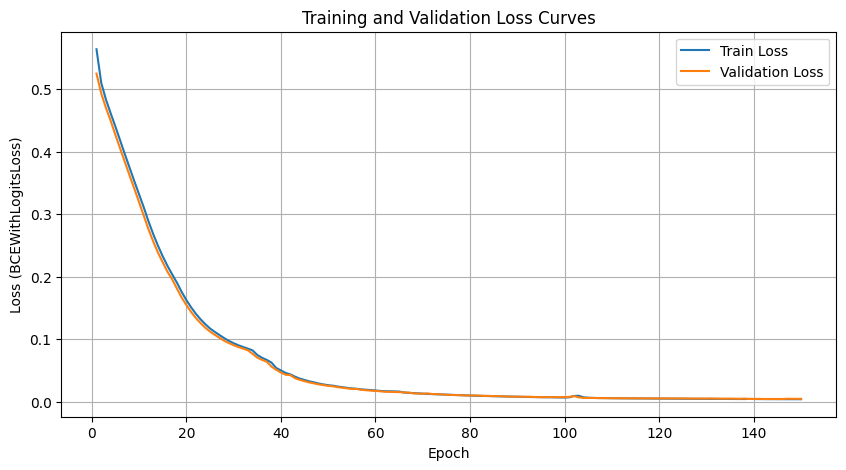

In [18]:
# --- Main Training Execution ---
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Starting Training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Training
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
    train_losses.append(train_loss)

    # Validation
    val_loss = validate_one_epoch(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)

    epoch_duration = time.time() - epoch_start_time

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Time: {epoch_duration:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # Update LR Scheduler
    scheduler.step(val_loss)

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"   -> New best model saved with Val Loss: {best_val_loss:.6f}")

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time/60:.2f} minutes")
print(f"Best Validation Loss: {best_val_loss:.6f}")
print(f"Model saved to: {MODEL_SAVE_PATH}")

# --- Plot Training Curves ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCEWithLogitsLoss)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig(RESULTS_DIR / "loss_curves.png")
plt.show()


In [19]:
def find_heatmap_peaks(heatmap, threshold=NMS_THRESHOLD, footprint_size=NMS_FOOTPRINT_SIZE):
    """Finds local maxima in a heatmap above a threshold."""
    # Apply maximum filter to find local peaks
    footprint = generate_binary_structure(heatmap.ndim, footprint_size) # Adjust connectivity as needed
    local_max = maximum_filter(heatmap, footprint=footprint) == heatmap

    # Apply threshold mask
    threshold_mask = heatmap > threshold

    # Combine masks
    peaks_mask = local_max & threshold_mask

    # Get coordinates of the peaks
    peak_coords = np.argwhere(peaks_mask) # Returns array of [z, y, x] indices
    peak_values = heatmap[peaks_mask]

    # Sort peaks by value (confidence) in descending order
    if len(peak_coords) > 0:
        sorted_indices = np.argsort(peak_values)[::-1]
        peak_coords = peak_coords[sorted_indices]
        peak_values = peak_values[sorted_indices]

    return peak_coords, peak_values # List of (z, y, x), List of confidences

def convert_patch_peak_to_world(peak_voxel_zyx, patch_origin_zyx, metadata):
    """Converts a peak's voxel coordinates relative to a patch back to world coordinates."""
    # 1. Absolute voxel coordinate in the resampled full volume
    absolute_voxel_zyx = patch_origin_zyx + peak_voxel_zyx

    # 2. Convert absolute voxel (z, y, x) to world coordinate (x, y, z)
    resampled_origin_xyz = metadata['resampled_origin']
    resampled_spacing_xyz = metadata['resampled_spacing']

    # Need absolute voxel in (x, y, z) order for voxel_to_world function
    # absolute_voxel_xyz = absolute_voxel_zyx[::-1] # Reverse z,y,x -> x,y,z
    # world_coord_xyz = voxel_to_world(absolute_voxel_xyz, resampled_origin_xyz, resampled_spacing_xyz)

    # Or calculate directly using numpy order (z, y, x) and spacing (x, y, z)
    # world_coord = origin + voxel * spacing
    # Note: SimpleITK origin/spacing is (x, y, z)
    world_coord_x = resampled_origin_xyz[0] + absolute_voxel_zyx[2] * resampled_spacing_xyz[0]
    world_coord_y = resampled_origin_xyz[1] + absolute_voxel_zyx[1] * resampled_spacing_xyz[1]
    world_coord_z = resampled_origin_xyz[2] + absolute_voxel_zyx[0] * resampled_spacing_xyz[2]
    world_coord_xyz = np.array([world_coord_x, world_coord_y, world_coord_z])

    return world_coord_xyz


# %% [markdown]
# ## 10. Inference Pipeline Example

# %%
def predict_scan_nodules(series_uid, model, metadata_dict, preprocessed_dir, device,
                         patch_size=PATCH_SIZE, stride=STRIDE, batch_size=BATCH_SIZE,
                         nms_threshold=NMS_THRESHOLD, nms_footprint=NMS_FOOTPRINT_SIZE):
    """Performs inference on a full scan using overlapping patches."""
    if series_uid not in metadata_dict:
        print(f"Error: Metadata not found for {series_uid}")
        return []

    meta = metadata_dict[series_uid]
    model.eval()

    # Load preprocessed volume
    volume_path = preprocessed_dir / f"{series_uid}_image.npy"
    if not volume_path.exists():
        print(f"Error: Preprocessed volume not found for {series_uid}")
        return []
    volume = np.load(volume_path)
    volume_tensor = torch.from_numpy(volume).float().unsqueeze(0).unsqueeze(0) # Add batch and channel dim

    # Get volume shape (z, y, x)
    scan_shape_zyx = np.array(volume.shape)
    patch_size_zyx = np.array(patch_size)
    stride_zyx = np.array(stride)

    # Prepare full-volume heatmap and count map (for averaging overlaps)
    full_heatmap = torch.zeros_like(volume_tensor, device='cpu', dtype=torch.float32) # Use CPU initially for potentially large volumes
    count_map = torch.zeros_like(volume_tensor, device='cpu', dtype=torch.float32)

    patch_origins = []
    # Generate patch start coordinates using strides
    for z in range(0, scan_shape_zyx[0] - patch_size_zyx[0] + 1, stride_zyx[0]):
        for y in range(0, scan_shape_zyx[1] - patch_size_zyx[1] + 1, stride_zyx[1]):
            for x in range(0, scan_shape_zyx[2] - patch_size_zyx[2] + 1, stride_zyx[2]):
                patch_origins.append(np.array([z, y, x]))

    # Handle edges: Add patches starting at the end minus patch size if needed
    end_coords = scan_shape_zyx - patch_size_zyx
    for z_flag in [False, True]:
         for y_flag in [False, True]:
             for x_flag in [False, True]:
                if not (z_flag or y_flag or x_flag): continue # Skip origin (0,0,0) handled above
                z = end_coords[0] if z_flag else 0
                y = end_coords[1] if y_flag else 0
                x = end_coords[2] if x_flag else 0
                # Only add if positive (scan larger than patch)
                if z >= 0 and y >= 0 and x >= 0:
                     origin = np.array([z, y, x])
                     # Avoid adding duplicate origins if stride covers edges perfectly
                     is_new = True
                     for existing in patch_origins:
                         if np.array_equal(origin, existing):
                             is_new = False
                             break
                     if is_new:
                         patch_origins.append(origin)


    print(f"Processing {series_uid} with {len(patch_origins)} patches...")

    # Process patches in batches
    patch_batch = []
    origin_batch = []
    with torch.no_grad():
        for origin_zyx in tqdm(patch_origins, desc=f"Inferring {series_uid}", leave=False):
            z, y, x = origin_zyx
            patch = volume_tensor[:, :, z:z+patch_size_zyx[0], y:y+patch_size_zyx[1], x:x+patch_size_zyx[2]]
            patch_batch.append(patch)
            origin_batch.append(origin_zyx)

            if len(patch_batch) == batch_size or origin_zyx is patch_origins[-1]:
                batch_tensor = torch.cat(patch_batch, dim=0).to(device)

                with autocast(enabled=scaler.is_enabled()):
                    outputs = model(batch_tensor)
                    # Apply sigmoid because BCEWithLogitsLoss was used (output are logits)
                    outputs = torch.sigmoid(outputs)

                outputs_cpu = outputs.cpu()

                # Add patch predictions to the full heatmap
                for i, patch_output in enumerate(outputs_cpu):
                    oz, oy, ox = origin_batch[i]
                    full_heatmap[:, :, oz:oz+patch_size_zyx[0], oy:oy+patch_size_zyx[1], ox:ox+patch_size_zyx[2]] += patch_output
                    count_map[:, :, oz:oz+patch_size_zyx[0], oy:oy+patch_size_zyx[1], ox:ox+patch_size_zyx[2]] += 1

                patch_batch = []
                origin_batch = []

    # Avoid division by zero
    count_map[count_map == 0] = 1
    # Average overlapping predictions
    averaged_heatmap = (full_heatmap / count_map).squeeze().numpy() # Shape: (D, H, W)

    # Find peaks in the averaged heatmap
    peak_voxels_zyx, peak_values = find_heatmap_peaks(averaged_heatmap, threshold=nms_threshold, footprint_size=nms_footprint)

    # Convert peak voxel coordinates to world coordinates
    detected_nodules = []
    for voxel_zyx, confidence in zip(peak_voxels_zyx, peak_values):
        world_coord_xyz = convert_patch_peak_to_world(voxel_zyx, np.array([0,0,0]), meta) # Origin is 0 for full volume

        # Estimate radius - very crude: use heatmap sigma or fixed value
        # A better approach would involve analysing the heatmap region or training a radius regressor.
        estimated_radius_mm = HEATMAP_SIGMA * np.mean(meta['resampled_spacing']) # Rough estimate based on sigma
        # Link to actual annotations for radius if needed during evaluation

        detected_nodules.append({
            'seriesuid': series_uid,
            'coordX': world_coord_xyz[0],
            'coordY': world_coord_xyz[1],
            'coordZ': world_coord_xyz[2],
            'voxelX': voxel_zyx[2], # Store voxel coords too for debugging/vis
            'voxelY': voxel_zyx[1],
            'voxelZ': voxel_zyx[0],
            'probability': confidence,
            'estimated_radius_mm': estimated_radius_mm
        })

    print(f"Found {len(detected_nodules)} candidate nodules in {series_uid}.")
    return detected_nodules, averaged_heatmap # Return heatmap for visualization


Loaded best model weights from /content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET/results_msa_unet/best_model_msa_unet.pth

Running inference on example scan: 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

<ipython-input-19-f6d5b560a694>:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 158 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Inference took 7.64 seconds.
Example detections:
  Coords (X,Y,Z): (117.90, 21.00, -154.00), Prob: 0.4114
  Coords (X,Y,Z): (182.90, -65.00, -100.00), Prob: 0.4109
  Coords (X,Y,Z): (182.90, 159.00, -100.00), Prob: 0.4104
  Coords (X,Y,Z): (-41.10, 159.00, -100.00), Prob: 0.4104
  Coords (X,Y,Z): (-41.10, 159.00, -357.00), Prob: 0.4104


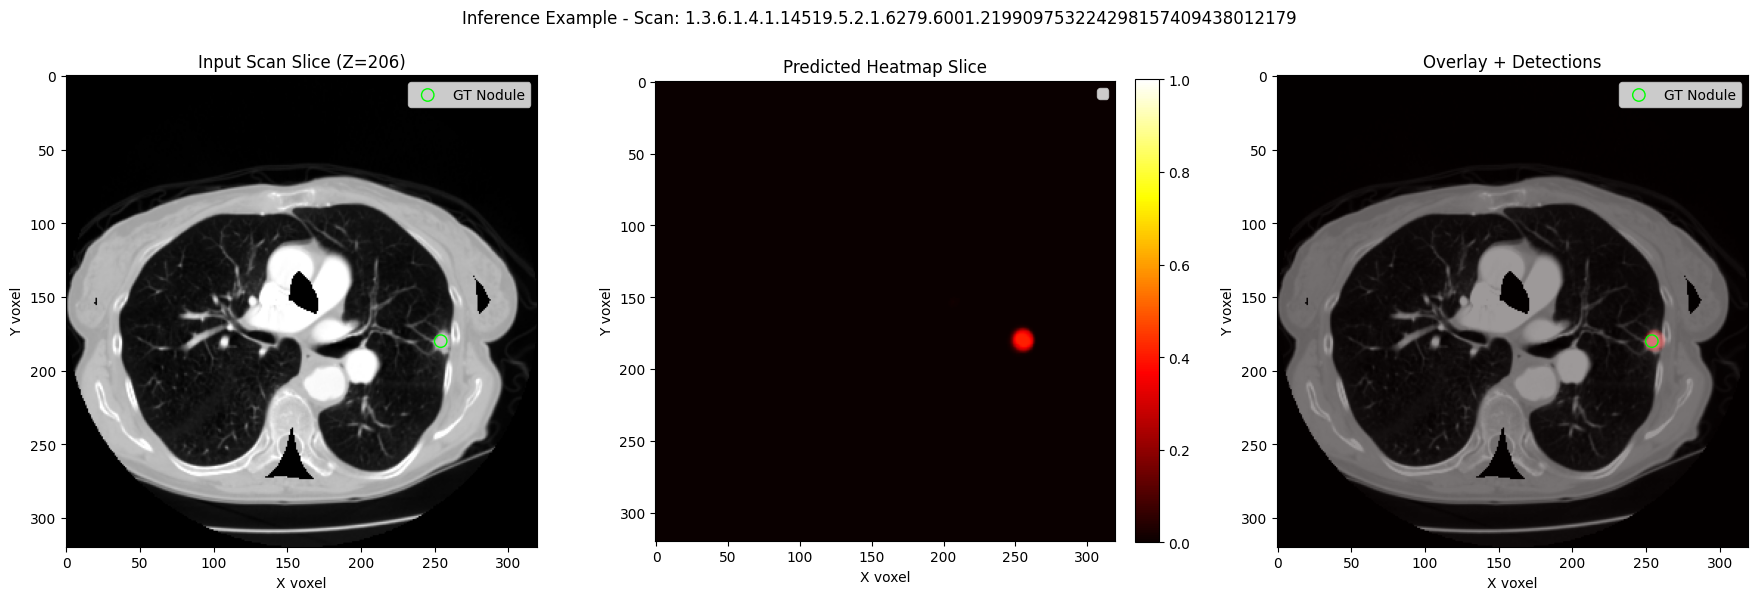

In [20]:
import numpy as np
from scipy.spatial.distance import cdist

def nms_3d(candidates, distance_threshold=5.0):
    """
    Apply 3D Non-Maximum Suppression to reduce overlapping detections.

    Args:
        candidates (list of dicts): Each dict should contain keys 'coordX', 'coordY', 'coordZ', 'probability'.
        distance_threshold (float): Minimum distance (in mm) to consider two detections as different nodules.

    Returns:
        List of filtered candidates after NMS.
    """
    if not candidates:
        return []

    # Sort candidates by descending probability
    candidates = sorted(candidates, key=lambda x: x['probability'], reverse=True)
    retained = []

    coords = np.array([[c['coordX'], c['coordY'], c['coordZ']] for c in candidates])
    suppressed = np.zeros(len(candidates), dtype=bool)

    for i in range(len(candidates)):
        if suppressed[i]:
            continue

        retained.append(candidates[i])
        # Compute distances from this candidate to all others
        dists = np.linalg.norm(coords - coords[i], axis=1)
        # Suppress those within the threshold
        suppressed = suppressed | (dists < distance_threshold)

        # Make sure current is not suppressed
        suppressed[i] = False

    return retained

# --- Example Inference on one validation scan ---
if val_uids:
    # Load the best model weights
    if MODEL_SAVE_PATH.exists():
        model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        print(f"Loaded best model weights from {MODEL_SAVE_PATH}")

        example_uid = random.choice(val_uids)
        print(f"\nRunning inference on example scan: {example_uid}")

        start_inf_time = time.time()
        candidate_nodules, predicted_heatmap = predict_scan_nodules(
              example_uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE
          )
        candidate_nodules = nms_3d(candidate_nodules, distance_threshold=5.0)
        inference_time = time.time() - start_inf_time

        print(f"Inference took {inference_time:.2f} seconds.")
        print("Example detections:")
        for nod in candidate_nodules[:5]: # Print first 5
            print(f"  Coords (X,Y,Z): ({nod['coordX']:.2f}, {nod['coordY']:.2f}, {nod['coordZ']:.2f}), Prob: {nod['probability']:.4f}")

        # --- Visualize Inference Result ---
        if example_uid in metadata_dict:
            # Load original preprocessed image for visualization context
            volume_path = PREPROCESSED_DIR / f"{example_uid}_image.npy"
            volume_np = np.load(volume_path)

            # Get ground truth nodules for this scan
            gt_nodules = annotations_df[annotations_df['seriesuid'] == example_uid]
            gt_centers_voxel = []
            meta = metadata_dict[example_uid]
            for _, row in gt_nodules.iterrows():
                wc = np.array([row['coordX'], row['coordY'], row['coordZ']])
                vc_xyz = world_to_voxel(wc, meta['resampled_origin'], meta['resampled_spacing'])
                vc_zyx = np.round(vc_xyz[::-1]).astype(int)
                if np.all(vc_zyx >= 0) and np.all(vc_zyx < volume_np.shape):
                     gt_centers_voxel.append(vc_zyx) # z, y, x

            # Find a slice with a GT nodule or a high-confidence prediction
            display_slice_z = volume_np.shape[0] // 2 # Default center slice
            if gt_centers_voxel:
                display_slice_z = gt_centers_voxel[0][0] # Use Z-coord of first GT nodule
            elif candidate_nodules:
                 display_slice_z = candidate_nodules[0]['voxelZ'] # Use Z-coord of highest-prob prediction

            display_slice_z = np.clip(display_slice_z, 0, volume_np.shape[0]-1) # Ensure valid index

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Image Slice
            axes[0].imshow(volume_np[display_slice_z, :, :], cmap='gray')
            axes[0].set_title(f'Input Scan Slice (Z={display_slice_z})')
            axes[0].set_xlabel('X voxel')
            axes[0].set_ylabel('Y voxel')

            # Heatmap Slice
            im = axes[1].imshow(predicted_heatmap[display_slice_z, :, :], cmap='hot', vmin=0, vmax=1)
            axes[1].set_title('Predicted Heatmap Slice')
            axes[1].set_xlabel('X voxel')
            axes[1].set_ylabel('Y voxel')
            fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)


            # Overlay Slice
            axes[2].imshow(volume_np[display_slice_z, :, :], cmap='gray')
            axes[2].imshow(predicted_heatmap[display_slice_z, :, :], cmap='hot', alpha=0.4, vmin=0.1, vmax=1.0) # Overlay heatmap
            axes[2].set_title('Overlay + Detections')
            axes[2].set_xlabel('X voxel')
            axes[2].set_ylabel('Y voxel')

            # Plot GT nodules on this slice
            for z, y, x in gt_centers_voxel:
                 if z == display_slice_z:
                     axes[0].scatter(x, y, color='lime', marker='o', s=80, facecolors='none', label='GT Nodule' if 'GT Nodule' not in [c.get_label() for c in axes[0].collections] else "")
                     axes[2].scatter(x, y, color='lime', marker='o', s=80, facecolors='none', label='GT Nodule' if 'GT Nodule' not in [c.get_label() for c in axes[2].collections] else "")


            # Plot detected nodules on this slice
            for nod in candidate_nodules:
                if nod['voxelZ'] == display_slice_z:
                     axes[1].scatter(nod['voxelX'], nod['voxelY'], color='cyan', marker='x', s=50, label='Detected Peak' if 'Detected Peak' not in [c.get_label() for c in axes[1].collections] else "")
                     axes[2].scatter(nod['voxelX'], nod['voxelY'], color='cyan', marker='x', s=50, label='Detected Peak' if 'Detected Peak' not in [c.get_label() for c in axes[2].collections] else "")


            axes[0].legend()
            axes[1].legend()
            axes[2].legend()
            plt.suptitle(f"Inference Example - Scan: {example_uid}")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.savefig(RESULTS_DIR / f"inference_example_{example_uid}.png")
            plt.show()

    else:
        print("Model file not found. Cannot run inference example.")
else:
    print("Validation set is empty. Cannot run inference example.")

In [22]:
# ## 11. Evaluation (FROC, Sensitivity, Confusion Matrix)
#
# This requires running inference on the entire validation set and comparing predictions against ground truth annotations. FROC evaluation is standard for LUNA16.
#
# **Note:** A full FROC evaluation is complex and involves matching predictions to GT nodules based on distance and handling multiple detections per nodule. We'll implement a simplified version focusing on sensitivity and basic metrics at a fixed detection threshold. For rigorous results, consider using established FROC calculation scripts (like those provided by LUNA or adapted versions).

# %%
def evaluate_predictions(all_predictions_df, ground_truth_df, metadata_dict, distance_threshold_mm=5.0):
    """
    Evaluates predictions against ground truth.

    Args:
        all_predictions_df (pd.DataFrame): DataFrame with columns ['seriesuid', 'coordX', 'coordY', 'coordZ', 'probability']
        ground_truth_df (pd.DataFrame): DataFrame with columns ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']
        metadata_dict (dict): Dictionary mapping seriesuid to metadata (needed if coordinate conversion is involved, but here assumes coords are already world).
        distance_threshold_mm (float): Maximum distance (in mm) for a prediction to be matched to a GT nodule.

    Returns:
        dict: Dictionary containing evaluation metrics (sensitivity, average FP per scan, etc.)
        pd.DataFrame: DataFrame with match status added to predictions.
    """
    predictions = all_predictions_df.copy()
    ground_truth = ground_truth_df.copy()

    predictions['matched_gt_index'] = -1
    predictions['distance_to_gt'] = np.inf
    predictions['is_tp'] = False
    ground_truth['is_detected'] = False
    ground_truth['detected_by_pred_index'] = -1

    # Group by seriesuid for matching
    all_series_uids = ground_truth['seriesuid'].unique()
    true_positives = 0
    false_positives = 0
    false_negatives = 0 # Total GT nodules - True Positives

    total_gt_nodules = len(ground_truth)
    num_scans = len(all_series_uids)

    matched_pairs = [] # Store (pred_idx, gt_idx, dist)

    print(f"Starting evaluation on {num_scans} scans with {total_gt_nodules} GT nodules and {len(predictions)} predictions.")

    for seriesuid in tqdm(all_series_uids, desc="Matching GT and Predictions"):
        gt_scan = ground_truth[ground_truth['seriesuid'] == seriesuid].reset_index()
        preds_scan = predictions[predictions['seriesuid'] == seriesuid].sort_values('probability', ascending=False).reset_index()

        if preds_scan.empty:
            continue # No predictions for this scan

        gt_coords = gt_scan[['coordX', 'coordY', 'coordZ']].values
        pred_coords = preds_scan[['coordX', 'coordY', 'coordZ']].values

        # Calculate pairwise distances (euclidean)
        # Using scipy's cdist is efficient
        from scipy.spatial.distance import cdist
        distances = cdist(pred_coords, gt_coords) # Shape: (num_preds, num_gt)

        # Greedy matching: Iterate through predictions (highest prob first)
        gt_matched_flags = np.zeros(len(gt_scan), dtype=bool)

        for pred_idx in range(len(preds_scan)):
            pred_row_idx = preds_scan.loc[pred_idx, 'index'] # Original index in 'predictions' df

            # Find closest GT nodule(s) within threshold for this prediction
            dists_to_pred = distances[pred_idx, :]
            possible_matches = np.where((dists_to_pred <= distance_threshold_mm) & (~gt_matched_flags))[0]

            if len(possible_matches) > 0:
                # Found one or more potential GT matches not yet matched
                # Choose the closest one
                best_match_gt_local_idx = possible_matches[np.argmin(dists_to_pred[possible_matches])]
                best_match_dist = dists_to_pred[best_match_gt_local_idx]

                # Mark this GT as matched
                gt_matched_flags[best_match_gt_local_idx] = True

                # Update prediction dataframe
                gt_row_idx = gt_scan.loc[best_match_gt_local_idx, 'index'] # Original index in 'ground_truth' df
                predictions.loc[pred_row_idx, 'matched_gt_index'] = gt_row_idx
                predictions.loc[pred_row_idx, 'distance_to_gt'] = best_match_dist
                predictions.loc[pred_row_idx, 'is_tp'] = True # This prediction is a True Positive

                # Update ground truth dataframe
                ground_truth.loc[gt_row_idx, 'is_detected'] = True
                ground_truth.loc[gt_row_idx, 'detected_by_pred_index'] = pred_row_idx

                matched_pairs.append((pred_row_idx, gt_row_idx, best_match_dist))
            else:
                # No available GT nodule within threshold, this prediction is a False Positive
                # (is_tp remains False, which indicates FP)
                pass # Already initialized as FP

    # Calculate overall metrics
    true_positives = predictions['is_tp'].sum()
    false_positives = len(predictions) - true_positives
    false_negatives = total_gt_nodules - ground_truth['is_detected'].sum() # GT nodules not detected by any prediction

    sensitivity = true_positives / total_gt_nodules if total_gt_nodules > 0 else 0
    avg_fp_per_scan = false_positives / num_scans if num_scans > 0 else 0

    metrics = {
        'total_gt_nodules': total_gt_nodules,
        'total_predictions': len(predictions),
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'sensitivity': sensitivity,
        'average_fp_per_scan': avg_fp_per_scan,
        'distance_threshold_mm': distance_threshold_mm,
        'num_scans_evaluated': num_scans
    }

    print("\nEvaluation Summary:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

    return metrics, predictions, ground_truth


def plot_froc_curve(predictions_df, ground_truth_df, num_scans, distance_threshold_mm=5.0):
    """Calculates and plots the FROC curve."""
    # Similar matching logic as evaluate_predictions, but done across thresholds
    all_predictions = []
    print("Calculating FROC points...")

    # Run inference on all validation scans
    if MODEL_SAVE_PATH.exists():
         model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
         print(f"Loaded best model weights from {MODEL_SAVE_PATH}")
    else:
         print("Model file not found. Cannot perform full evaluation.")
         return

    for uid in tqdm(val_uids, desc="Running inference for FROC"):
         preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2) # Use larger batch for inference
         all_predictions.extend(preds)

    if not all_predictions:
         print("No predictions generated. Cannot compute FROC.")
         return

    predictions_df = pd.DataFrame(all_predictions)
    ground_truth = ground_truth_df[ground_truth_df['seriesuid'].isin(val_uids)].copy() # Only GT for validation scans
    total_gt_nodules = len(ground_truth)
    num_scans = len(val_uids)

    if total_gt_nodules == 0:
        print("No ground truth nodules found in validation set.")
        return

    # Sort predictions by probability
    predictions_df = predictions_df.sort_values('probability', ascending=False).reset_index(drop=True)

    sensitivities = []
    avg_fps = []
    thresholds = np.unique(predictions_df['probability']) # Use unique probabilities as thresholds
    thresholds = np.append(thresholds, 0) # Add 0 threshold
    thresholds = np.sort(thresholds)[::-1] # High to low prob

    gt_coords_map = {}
    for uid in val_uids:
        gt_scan = ground_truth[ground_truth['seriesuid'] == uid]
        if not gt_scan.empty:
             gt_coords_map[uid] = gt_scan[['coordX', 'coordY', 'coordZ']].values
        else:
             gt_coords_map[uid] = np.empty((0,3))


    # Pre-calculate GT indices for faster lookup
    gt_indices_map = {uid: ground_truth[ground_truth['seriesuid'] == uid].index for uid in val_uids}


    for thresh in tqdm(thresholds, desc="Calculating FROC points", leave=False):
        preds_above_thresh = predictions_df[predictions_df['probability'] >= thresh]
        num_preds_at_thresh = len(preds_above_thresh)

        tp = 0
        fp = 0
        gt_detected_at_thresh = {idx: False for idx_list in gt_indices_map.values() for idx in idx_list} # Reset detection status for each threshold


        # Iterate through predictions above threshold for matching
        for _, pred_row in preds_above_thresh.iterrows():
            seriesuid = pred_row['seriesuid']
            pred_coord = pred_row[['coordX', 'coordY', 'coordZ']].values

            if seriesuid not in gt_coords_map or gt_coords_map[seriesuid].shape[0] == 0:
                fp += 1 # FP if no GT nodules exist for this scan
                continue

            gt_coords_scan = gt_coords_map[seriesuid]
            gt_indices_scan = gt_indices_map[seriesuid]

            distances = np.linalg.norm(gt_coords_scan - pred_coord, axis=1)
            possible_matches = np.where(distances <= distance_threshold_mm)[0]

            best_match_gt_local_idx = -1
            min_dist = np.inf

            # Find the closest *available* GT match
            for local_idx in possible_matches:
                global_gt_idx = gt_indices_scan[local_idx]
                if not gt_detected_at_thresh[global_gt_idx]: # If this GT nodule hasn't been detected yet at this threshold
                     if distances[local_idx] < min_dist:
                         min_dist = distances[local_idx]
                         best_match_gt_local_idx = local_idx


            if best_match_gt_local_idx != -1:
                 # Found a match, mark GT as detected for this threshold
                 global_gt_idx = gt_indices_scan[best_match_gt_local_idx]
                 gt_detected_at_thresh[global_gt_idx] = True
                 tp += 1
            else:
                 # No available match found within distance, it's an FP
                 fp += 1

        sensitivity = tp / total_gt_nodules if total_gt_nodules > 0 else 0
        avg_fp = fp / num_scans if num_scans > 0 else 0

        sensitivities.append(sensitivity)
        avg_fps.append(avg_fp)


    # Plot FROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(avg_fps, sensitivities, marker='o', linestyle='-')
    plt.xlabel('Average False Positives per Scan')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title(f'Free-response Receiver Operating Characteristic (FROC) Curve\n(Distance Threshold: {distance_threshold_mm}mm)')
    # Standard LUNA evaluation points
    froc_points_target = [0.125, 0.25, 0.5, 1, 2, 4, 8]
    plt.xticks(froc_points_target + [0])
    plt.xlim(left=0)
    plt.ylim(0, 1.05)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Annotate sensitivity at standard FP rates
    sens_at_fp = []
    for fp_target in froc_points_target:
         sens = np.interp(fp_target, avg_fps, sensitivities) # Linear interpolation
         sens_at_fp.append(sens)
         plt.scatter(fp_target, sens, color='red', zorder=5)
         plt.text(fp_target + 0.1, sens, f'{sens:.3f}', color='red', va='bottom')

    print("\nSensitivity @ FP rates:")
    for fp_val, sens_val in zip(froc_points_target, sens_at_fp):
        print(f"  @ {fp_val:.3f} FP/scan: {sens_val:.4f}")

    # Calculate Competition Performance Metric (CPM) - average sensitivity at the standard points
    cpm = np.mean(sens_at_fp)
    print(f"\nCompetition Performance Metric (CPM): {cpm:.4f}")
    plt.text(0.5, 0.1, f"CPM = {cpm:.4f}", transform=plt.gca().transAxes, ha='center')

    plt.savefig(RESULTS_DIR / "froc_curve.png")
    plt.show()

    return {'sensitivities': sensitivities, 'avg_fps': avg_fps, 'thresholds': thresholds, 'cpm': cpm}


# --- Run Evaluation ---
# First, generate predictions for all validation scans
all_predictions_list = []
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"\nLoaded best model weights from {MODEL_SAVE_PATH} for evaluation.")
    print("Generating predictions for all validation scans...")
    for uid in tqdm(val_uids, desc="Final Evaluation Inference"):
        preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2)
        all_predictions_list.extend(preds)

    if all_predictions_list:
        all_predictions_df = pd.DataFrame(all_predictions_list)

        # --- Evaluate at a fixed threshold (e.g., NMS threshold used in inference) ---
        print(f"\n--- Evaluating at fixed threshold: {NMS_THRESHOLD} ---")
        # We need GT for validation set only
        val_gt_df = annotations_df[annotations_df['seriesuid'].isin(val_uids)].copy()

        # Filter predictions by the chosen threshold before evaluation
        predictions_at_threshold_df = all_predictions_df[all_predictions_df['probability'] >= NMS_THRESHOLD].copy()

        eval_metrics, preds_eval_df, gt_eval_df = evaluate_predictions(
            predictions_at_threshold_df,
            val_gt_df,
            metadata_dict,
            distance_threshold_mm=5.0 # Common threshold, adjust if needed
        )

        # --- Confusion Matrix at this threshold ---
        # Based on the matched results
        # TP = eval_metrics['true_positives']
        # FP = eval_metrics['false_positives']
        # FN = eval_metrics['false_negatives']
        # TN = ? Hard to define True Negatives at candidate level. Often omitted.
        # We can visualize based on TP, FP, FN counts
        print("\nConfusion Matrix (Candidate Level):")
        print(f"  True Positives (Detected Nodules): {eval_metrics['true_positives']}")
        print(f"  False Positives (Incorrect Detections): {eval_metrics['false_positives']}")
        print(f"  False Negatives (Missed Nodules): {eval_metrics['false_negatives']}")

        # --- Plot FROC Curve ---
        print("\n--- Generating FROC Curve ---")
        froc_results = plot_froc_curve(all_predictions_df, annotations_df, len(val_uids), distance_threshold_mm=5.0)

    else:
        print("No predictions were generated for the validation set.")

else:
    print("Best model not found. Cannot run evaluation.")


Loaded best model weights from /content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET/results_msa_unet/best_model_msa_unet.pth for evaluation.
Generating predictions for all validation scans...


Final Evaluation Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686:   0%|          | 0/187 [00:00<?, ?…

<ipython-input-19-f6d5b560a694>:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 296 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865:   0%|          | 0/151 [00:00<?, ?…

Found 80 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 158 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111 with 132 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111:   0%|          | 0/132 [00:00<?, ?…

Found 75 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509:   0%|          | 0/187 [00:00<?, ?…

Found 109 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.

--- Evaluating at fixed threshold: 0.1 ---
Starting evaluation on 4 scans with 7 GT nodules and 718 predictions.


Matching GT and Predictions:   0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Summary:
  total_gt_nodules: 7
  total_predictions: 718
  true_positives: 3
  false_positives: 715
  false_negatives: 4
  sensitivity: 0.4286
  average_fp_per_scan: 178.7500
  distance_threshold_mm: 5.0000
  num_scans_evaluated: 4

Confusion Matrix (Candidate Level):
  True Positives (Detected Nodules): 3
  False Positives (Incorrect Detections): 715
  False Negatives (Missed Nodules): 4

--- Generating FROC Curve ---
Calculating FROC points...
Loaded best model weights from /content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET/results_msa_unet/best_model_msa_unet.pth


Running inference for FROC:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686:   0%|          | 0/187 [00:00<?, ?…

<ipython-input-19-f6d5b560a694>:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 296 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865:   0%|          | 0/151 [00:00<?, ?…

Found 80 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 158 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111 with 132 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111:   0%|          | 0/132 [00:00<?, ?…

Found 75 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509:   0%|          | 0/187 [00:00<?, ?…

Found 109 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.


Calculating FROC points:   0%|          | 0/413 [00:00<?, ?it/s]

TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method

In [23]:
if MODEL_SAVE_PATH.exists():
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"\n✅ Loaded best model weights from {MODEL_SAVE_PATH} for evaluation.")
    print("🚀 Generating predictions for all validation scans...")

    all_predictions_list = []

    for uid in tqdm(val_uids, desc="Final Evaluation Inference"):
        preds, _ = predict_scan_nodules(uid, model, metadata_dict, PREPROCESSED_DIR, DEVICE, batch_size=BATCH_SIZE*2)
        all_predictions_list.extend(preds)

    if all_predictions_list:
        all_predictions_df = pd.DataFrame(all_predictions_list)

        # --- Evaluate at a fixed threshold (e.g., NMS threshold used in inference) ---
        print(f"\n📏 Evaluating at fixed threshold: {NMS_THRESHOLD}")
        val_gt_df = annotations_df[annotations_df['seriesuid'].isin(val_uids)].copy()

        # Filter predictions by probability threshold
        predictions_at_threshold_df = all_predictions_df[all_predictions_df['probability'] >= NMS_THRESHOLD].copy()

        eval_metrics, preds_eval_df, gt_eval_df = evaluate_predictions(
            predictions_at_threshold_df,
            val_gt_df,
            metadata_dict,
            distance_threshold_mm=5.0  # Adjustable threshold (5mm is standard)
        )

        # --- Display basic candidate-level metrics ---
        print("\n📊 Confusion Matrix (Candidate Level Approximation):")
        print(f"  ✅ True Positives (Detected Nodules): {eval_metrics['true_positives']}")
        print(f"  ❌ False Positives (Incorrect Detections): {eval_metrics['false_positives']}")
        print(f"  ❗ False Negatives (Missed Nodules): {eval_metrics['false_negatives']}")

    else:
        print("⚠️ No predictions were generated for the validation set.")

else:
    print("❌ Best model not found. Cannot run evaluation.")


✅ Loaded best model weights from /content/drive/MyDrive/Datasets/Preprocessed Luna Plus UNET/results_msa_unet/best_model_msa_unet.pth for evaluation.
🚀 Generating predictions for all validation scans...


Final Evaluation Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686:   0%|          | 0/187 [00:00<?, ?…

<ipython-input-19-f6d5b560a694>:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler.is_enabled()):


Found 296 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865 with 151 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865:   0%|          | 0/151 [00:00<?, ?…

Found 80 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179 with 157 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179:   0%|          | 0/157 [00:00<?, ?…

Found 158 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111 with 132 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111:   0%|          | 0/132 [00:00<?, ?…

Found 75 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.
Processing 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509 with 187 patches...


Inferring 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509:   0%|          | 0/187 [00:00<?, ?…

Found 109 candidate nodules in 1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.

📏 Evaluating at fixed threshold: 0.1
Starting evaluation on 4 scans with 7 GT nodules and 718 predictions.


Matching GT and Predictions:   0%|          | 0/4 [00:00<?, ?it/s]


Evaluation Summary:
  total_gt_nodules: 7
  total_predictions: 718
  true_positives: 3
  false_positives: 715
  false_negatives: 4
  sensitivity: 0.4286
  average_fp_per_scan: 178.7500
  distance_threshold_mm: 5.0000
  num_scans_evaluated: 4

📊 Confusion Matrix (Candidate Level Approximation):
  ✅ True Positives (Detected Nodules): 3
  ❌ False Positives (Incorrect Detections): 715
  ❗ False Negatives (Missed Nodules): 4
